In [210]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from ipywidgets import Button, Output
from IPython.display import display
import os
import time

## step 1
### data load and checking

Unique Disease Labels: {'Emphysema', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Pleural_Thickening', 'No Finding', 'Infiltration', 'Fibrosis', 'Cardiomegaly', 'Mass', 'Nodule', 'Atelectasis', 'Edema', 'Hernia', 'Effusion'}


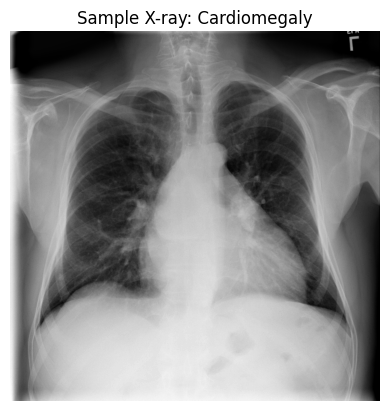

In [211]:
# Define paths
data_path = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/metadata/Data_Entry_2017.csv"
image_folder = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images/"

# Load the CSV file
df = pd.read_csv(data_path)

# Checking how many unique labels exist
unique_labels = set()
for labels in df["Finding Labels"]:
    unique_labels.update(labels.split("|"))  # Split multi-label cases

print("Unique Disease Labels:", unique_labels)

# Load a sample image
sample_image = os.path.join(image_folder, df.iloc[0]["Image Index"])
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

# Display the sample image
plt.imshow(img, cmap="gray")
plt.title(f"Sample X-ray: {df.iloc[0]['Finding Labels']}")
plt.axis("off")
plt.show()


Fractured images: 4589
Not Fractured images: 4640


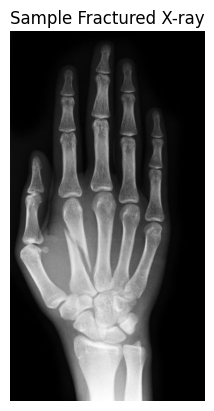

In [212]:
# Define paths
fracture_dir = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures"
fractured_path = os.path.join(fracture_dir, "fractured")
not_fractured_path = os.path.join(fracture_dir, "not_fractured")

# Check the number of images
print("Fractured images:", len(os.listdir(fractured_path)))
print("Not Fractured images:", len(os.listdir(not_fractured_path)))

# Load and display a sample fractured image
sample_image = os.path.join(fractured_path, os.listdir(fractured_path)[0])
img = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.title("Sample Fractured X-ray")
plt.axis("off")
plt.show()


# step 2
### EDA

In [213]:
# Load the CSV file
df = pd.read_csv(data_path)

# Create a dictionary to store condition counts
condition_counts = {}

# Count occurrences of each condition
for labels in df["Finding Labels"]:
    # For each image, split its conditions and count them
    conditions = labels.split("|")
    for condition in conditions:
        condition_counts[condition] = condition_counts.get(condition, 0) + 1

# Convert to DataFrame and sort by frequency
conditions_df = pd.DataFrame(
    list(condition_counts.items()),
    columns=['Condition', 'Count']
).sort_values('Count', ascending=False)

# Add percentage column
total_images = len(df)
conditions_df['Percentage'] = (conditions_df['Count'] / total_images * 100).round(2)

# Display the results
print("Total number of images:", total_images)
print("\nCondition Distribution:")
print(conditions_df)

Total number of images: 112120

Condition Distribution:
             Condition  Count  Percentage
3           No Finding  60361       53.84
5         Infiltration  19894       17.74
2             Effusion  13317       11.88
8          Atelectasis  11559       10.31
7               Nodule   6331        5.65
6                 Mass   5782        5.16
9         Pneumothorax   5302        4.73
14       Consolidation   4667        4.16
10  Pleural_Thickening   3385        3.02
0         Cardiomegaly   2776        2.48
1            Emphysema   2516        2.24
13               Edema   2303        2.05
12            Fibrosis   1686        1.50
11           Pneumonia   1431        1.28
4               Hernia    227        0.20


### image preprocessing

In [214]:
def load_and_preprocess_image(image_path, target_size=(224, 224), save_flag=False):
    """
    Load and preprocess an X-ray image with automatic folder creation for processed images.
    The processed images will be saved in a new folder that adds '_processed' to the original folder name.

    Args:
        image_path (str): Path to the original X-ray image
        target_size (tuple): Desired size for the processed image (default: 224x224)
        save_flag (bool): If True, save the processed image; if False, return it
    Returns:
        1. folder with processed images if save_flag is True
        2. A processed image that can be used directly
    """

    # loading greyscale xray images
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

    # Checking if image was loaded successfully
    if image is None:
        print(f"Error: Failed to load image: {image_path}")
        return None

    # creating a try exception block for catching exceptions in images
    try:
        # Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) because
        # 1. it enhances the contrast of the X-ray while limiting noise amplification
        # 2. this in turn helps us in making subtle details more visible while preventing over-enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)

        # Resizing the image while maintaining aspect ratio we are doing this because
        # 1. We need a consistent image size for our neural network
        # 2. preserving the aspect ratio helps preserve the relative size of features in the image

        # getting the current dimensions
        current_height, current_width = image.shape

        # calculating the scaling
        scale = min(target_size[0] / current_width, target_size[1] / current_height)
        new_width = int(current_width * scale)
        new_height = int(current_height * scale)
        resized = cv2.resize(image, (new_width, new_height))

        # creating a black canvas of target size as it helps us in
        # 1. ensuring all images have exactly the same dimensions
        # 2. preserves their aspect ratios through padding
        final_image = np.zeros(target_size, dtype=np.float32)
        y_offset = (target_size[0] - new_height) // 2
        x_offset = (target_size[1] - new_width) // 2
        final_image[y_offset:y_offset + new_height,
        x_offset:x_offset + new_width] = resized

        # normalising pixel values to range [0,1] because
        # 1. helps with model convergence
        # 2. makes the learning process more stable
        final_image = final_image / 255.0

        # checking whether to save or return the image
        if save_flag:

            # creating folder name for processed images
            original_folder = os.path.dirname(image_path)
            processed_folder = original_folder + '_processed'

            # creating the folder for processed images
            os.makedirs(processed_folder, exist_ok=True)

            # recreate original output filenames
            base_name = os.path.basename(image_path)
            file_name = os.path.splitext(base_name)[0] + '.npy'     # Saving as .npy to preserve exact numerical values (0-1) and floating point precision for                                                             # training as using this would help us avoid the data loss that would occur with regular image
                                                                    # format (jpg/png) as they round the value whereas npy stores numerical arrays as it is
            save_path = os.path.join(processed_folder, file_name)

            # Saving the processed image
            np.save(save_path, final_image)
            return None
        else:
            return final_image


    except Exception as e:
        print(f"Error during processing: {str(e)}")
        return None

In [215]:
# 1. First, define paths where our preprocessed .npy files are stored
fracture_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured_processed"
not_fracture_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/not_fractured_processed"
chest_processed = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images_processed"

# Path to the CSV file containing chest X-ray labels
chest_csv_path = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/metadata/Data_Entry_2017.csv"

In [216]:
# Load the CSV file
df = pd.read_csv(chest_csv_path)

# List of single labels
single_labels = ['Nodule', 'Pneumothorax', 'No Finding', 'Fibrosis', 'Mass', 'Edema',
                 'Pleural_Thickening', 'Consolidation', 'Infiltration', 'Effusion',
                 'Atelectasis', 'Cardiomegaly', 'Emphysema', 'Pneumonia', 'Hernia']

# Filter for single labels
single_label_df = df[df['Finding Labels'].isin(single_labels)]

# Verify the result
print(f"Original DataFrame size: {len(df)}")
print(f"Single-label DataFrame size: {len(single_label_df)}")

# Get value counts of the finding labels
print(single_label_df['Finding Labels'].value_counts())

Original DataFrame size: 112120
Single-label DataFrame size: 91324
Finding Labels
No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: count, dtype: int64


In [217]:
# under sampling to adjust our bias
no_finding_df = single_label_df[single_label_df['Finding Labels'] == 'No Finding']
other_conditions_df = single_label_df[single_label_df['Finding Labels'] != 'No Finding']

undersampled_no_finding_df = no_finding_df.sample(n=12000, random_state=42)

final_chest_df = pd.concat([undersampled_no_finding_df, other_conditions_df])

# Verify the result
print(f"Undersampled Chest DataFrame size: {len(final_chest_df)}")
print(final_chest_df['Finding Labels'].value_counts())

Undersampled Chest DataFrame size: 42963
Finding Labels
No Finding            12000
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: count, dtype: int64


In [219]:
a = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured"
b = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/not_fractured"
c = "/Users/debabratapanda/PycharmProjects/Capstone_project/dataset/chest_xrays/images"
fi = [a, b, c]
for i in fi:
    print(f"proceessing folder with {os.path.basename(i)} images")
    for image_name in tqdm(os.listdir(i)):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            input_path = os.path.join(i, image_name)
            load_and_preprocess_image(input_path, save_flag=True)

proceessing folder with fractured images


  0%|          | 0/4589 [00:00<?, ?it/s]

libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile


Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured/26(1).jpg
Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured/159.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: bKGD: invalid


Error: Failed to load image: /Users/debabratapanda/PycharmProjects/Capstone_project/dataset/bone_fractures/fractured/2.jpg


libpng warning: iCCP: known incorrect sRGB profile


proceessing folder with not_fractured images


  0%|          | 0/4640 [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


proceessing folder with images images


  0%|          | 0/112120 [00:00<?, ?it/s]

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


In [221]:
def create_dataset_df(final_chest_df, chest_processed, fracture_processed, not_fracture_processed):
    """
    Creates a unified DataFrame with multi-hot encoded chest conditions and all image paths.
    """
    # Fracture dataset paths
    fracture_files = [(os.path.join(fracture_processed, f), 1, 'fracture')
                      for f in os.listdir(fracture_processed) if f.endswith('.npy')]
    not_fracture_files = [(os.path.join(not_fracture_processed, f), 0, 'not fracture')
                          for f in os.listdir(not_fracture_processed) if f.endswith('.npy')]
    fracture_df = pd.DataFrame(fracture_files + not_fracture_files,
                               columns=['file_path', 'fracture_label', 'dataset_type'])

    # Chest X-ray dataset paths
    # chest_labels_df is now final_chest_df
    chest_labels_df = final_chest_df

    # Create mapping dictionary for chest conditions
    all_conditions = set(chest_labels_df['Finding Labels'].unique())

    # Create mapping dictionary starting from 0
    condition_to_idx = {condition: idx for idx, condition
                        in enumerate(sorted(all_conditions))}

    # Function to create multi-hot encoded labels (now single hot)
    def create_single_hot(label_str):
        single_hot = [0] * len(condition_to_idx)
        single_hot[condition_to_idx[label_str]] = 1
        return single_hot

    # Add multi-hot encoded labels to chest_labels_df
    chest_labels_df['chest_labels'] = chest_labels_df['Finding Labels'].apply(create_single_hot)

    chest_files = [(os.path.join(chest_processed, f.replace('.png', '.npy')), f, 'chest')
                    for f in chest_labels_df['Image Index']]

    chest_df = pd.DataFrame(chest_files,
                            columns=['file_path', 'original_filename', 'dataset_type'])

    # Merge with chest_labels column
    chest_df = chest_df.merge(chest_labels_df[['Image Index', 'chest_labels', 'Finding Labels']],
                                left_on='original_filename',
                                right_on='Image Index',
                                how='left')

    # Combine datasets
    combined_df = pd.concat([fracture_df, chest_df], ignore_index=True)

    return combined_df, condition_to_idx

In [222]:
# Create the organized DataFrame
dataset_df,chest_condition_map = create_dataset_df(final_chest_df, chest_processed, fracture_processed, not_fracture_processed)
dataset_df

,file_path,fracture_label,dataset_type,original_filename,Image Index,chest_labels,Finding Labels
0,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN
1,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN
2,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN
3,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN
4,/Users/debabratapanda/PycharmProjects/Capstone...,1.0,fracture,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
52174,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030780_000.png,00030780_000.png,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Atelectasis
52175,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030786_000.png,00030786_000.png,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Effusion
52176,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030786_006.png,00030786_006.png,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Consolidation
52177,/Users/debabratapanda/PycharmProjects/Capstone...,NaN,chest,00030789_000.png,00030789_000.png,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",Infiltration


In [223]:
# Check dataset sizes
print("Dataset distribution:")
print(dataset_df['chest_labels'].value_counts())

Dataset distribution:
chest_labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]    12000
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]     9547
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     4215
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     3955
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]     2705
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]     2194
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]     2139
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     1310
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]     1126
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     1093
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]      892
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]      727
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]      628
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]      322
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]      110
Name: count, dtype: int64


In [224]:
# Function to split dataset in train validation and test sets
def split_datasets(dataset_df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    This function will split the combined dataset (fracture and chest X-ray data) into training, validation, and test sets,
    maintaining class balance, especially for 'No Finding' vs. 'Findings' in chest X-ray data.

    Args:
        dataset_df (pd.DataFrame): Combined DataFrame containing both fracture and chest X-ray datasets.
        train_size (float): Proportion of the dataset to include in the training split (default: 0.7).
        val_size (float): Proportion of the dataset to include in the validation split (default: 0.15).
        test_size (float): Proportion of the dataset to include in the test split (default: 0.15).
        random_state (int): Seed used by the random number generator for reproducible splits (default: 42).

    Returns:
        tuple: A tuple containing three pandas DataFrames: (train_data, val_data, test_data).
               Each DataFrame represents the training, validation, and test splits, respectively.
    """

    # --- Separate Fracture and Chest Datasets ---
    # We're separating the combined DataFrame into fracture and chest X-ray DataFrames based on 'dataset_type'.
    # This helps us prevent class imbalance, especially since the chest X-ray data is much larger than the fracture data.
    fracture_data = dataset_df[dataset_df['dataset_type'].isin(['fracture', 'not fracture'])]
    chest_data = dataset_df[dataset_df['dataset_type'] == 'chest']

    # --- Splitting Fracture Dataset ---
    # 1. we will start by splitting the fracture data. We'll use a temporary set here which we'll then divide into validation and test sets.
    # 2. we also are using the stratify parameter to make sure we keep a balanced representation of fracture/not fracture classes.
    fracture_train, fracture_temp = train_test_split(
        fracture_data,
        train_size=train_size,
        stratify=fracture_data['dataset_type'],  # Stratify by fracture/not fracture
        random_state=random_state
    )

    # Step 2: Split the temporary fracture set into validation and test sets.
    # 3. now we will calculate the relative validation size and split the temporary set to form the validation and test sets.
    relative_val_size = val_size / (val_size + test_size)
    fracture_val, fracture_test = train_test_split(
        fracture_temp,
        train_size=relative_val_size,
        stratify=fracture_temp['dataset_type'],  # Stratify by fracture/not fracture
        random_state=random_state
    )

    # --- Split Chest X-ray Dataset, Maintaining Balance ---
    # 1. now we are going to split the chest X-ray data, but we'll do it a bit differently to ensure balance across the various classes.
    # 2. we are going to split it on the basis of No Finding vs. other findings to maintain a good mix in each set as the no findings data have a very high percentage in there which can make the selection based and un balanced .
    no_finding_data = chest_data[chest_data['Finding Labels'] == 'No Finding']
    findings_data = chest_data[chest_data['Finding Labels'] != 'No Finding']

    # 3. splitting the No Finding data into training and temporary data
    no_finding_train, no_finding_temp = train_test_split(
        no_finding_data,
        train_size=train_size,
        random_state=random_state
    )

    # 4. splitting the temporary data into validation and test data
    no_finding_val, no_finding_test = train_test_split(
        no_finding_temp,
        train_size=relative_val_size,
        random_state=random_state
    )

    # 5. splitting the Finding data into training and temporary data
    findings_train, findings_temp = train_test_split(
        findings_data,
        train_size=train_size,
        random_state=random_state
    )
    # 6. splitting the temporary data into validation and test data
    findings_val, findings_test = train_test_split(
        findings_temp,
        train_size=relative_val_size,
        random_state=random_state
    )

    # 7. now we merge both the data to get our combined data for the chest data
    chest_train = pd.concat([no_finding_train, findings_train])
    chest_val = pd.concat([no_finding_val, findings_val])
    chest_test = pd.concat([no_finding_test, findings_test])

    # --- Combine Splits ---
    # 1.now we will put all the data together and combine the fracture and chest splits to obtain our final training, validation and test sets.
    train_data = pd.concat([fracture_train, chest_train])
    val_data = pd.concat([fracture_val, chest_val])
    test_data = pd.concat([fracture_test, chest_test])

    # --- Print Final Dataset Sizes ---
    # 1. as a last step we will print the dataset sizes to check Just to double-check, let's print the final sizes of our training, validation, and test sets.
    print("\nAfter splitting:")
    print(f"Train set size: {len(train_data)} (Fracture: {len(fracture_train)}, Chest: {len(chest_train)})")
    print(f"Validation set size: {len(val_data)} (Fracture: {len(fracture_val)}, Chest: {len(chest_val)})")
    print(f"Test set size: {len(test_data)} (Fracture: {len(fracture_test)}, Chest: {len(chest_test)})")

    # --- Return Split Datasets ---
    # 1. finally, we'll return the training, validation, and test DataFrames.
    return train_data, val_data, test_data

In [225]:
train_data, val_data, test_data = split_datasets(dataset_df)



After splitting:
Train set size: 36525 (Fracture: 6451, Chest: 30074)
Validation set size: 7826 (Fracture: 1382, Chest: 6444)
Test set size: 7828 (Fracture: 1383, Chest: 6445)


In [226]:
def create_batch_generator(train_data, condition_to_idx, batch_size=32, no_finding_weight=0.5):
    """Creates balanced batches with weighted sampling for 'No Finding'."""

    # Separate data
    fracture_data = train_data[train_data['dataset_type'].isin(['fracture', 'not fracture'])]
    chest_data = train_data[train_data['dataset_type'] == 'chest']
    no_finding_data = chest_data[chest_data['Finding Labels'] == 'No Finding']
    findings_data = chest_data[chest_data['Finding Labels'] != 'No Finding']

    # Calculate batch sizes
    fracture_batch_size = batch_size // 2
    no_finding_size = int(fracture_batch_size * no_finding_weight)
    findings_size = fracture_batch_size - no_finding_size

    # Calculate number of complete batches
    num_batches = min(
        len(fracture_data) // fracture_batch_size,
        len(no_finding_data) // no_finding_size,
        len(findings_data) // findings_size
    )

    # Create random indices
    fracture_indices = np.random.permutation(len(fracture_data))
    no_finding_indices = np.random.permutation(len(no_finding_data))
    findings_indices = np.random.permutation(len(findings_data))

    for batch_idx in tqdm(range(num_batches), desc='Generating Batches'):
        # Get indices for this batch
        fracture_batch_idx = fracture_indices[batch_idx * fracture_batch_size:(batch_idx + 1) * fracture_batch_size]
        no_finding_batch_idx = no_finding_indices[batch_idx * no_finding_size:(batch_idx + 1) * no_finding_size]
        findings_batch_idx = findings_indices[batch_idx * findings_size:(batch_idx + 1) * findings_size]

        # Get the data
        fracture_batch = fracture_data.iloc[fracture_batch_idx]
        no_finding_batch = no_finding_data.iloc[no_finding_batch_idx]
        findings_batch = findings_data.iloc[findings_batch_idx]

        # Combine all data
        batch = pd.concat([fracture_batch, no_finding_batch, findings_batch])
        batch_images = []
        batch_labels = []

        for _, row in batch.iterrows():
            # Load the original image
            img = np.load(row['file_path'])
            img = img.reshape(1, 224, 224)

            batch_images.append(img)

            # Use original working label format
            if row['dataset_type'] in ['fracture', 'not fracture']:
                label = np.array([float(row['fracture_label'])] + [0.0] * len(condition_to_idx))
            else:
                chest_label_vector = row['chest_labels']
                label = np.array([0.0] + chest_label_vector)
            batch_labels.append(label)

        batch_images = np.stack(batch_images)
        batch_labels = np.stack(batch_labels)

        yield batch_images, batch_labels

In [227]:
# proposed model architecture
# X-ray Image
#     ↓
# Initial Conv
#     ↓
# Dense Block 1 (6 layers)
#     ↓
# Transition Layer
#     ↓
# Dense Block 2 (12 layers)
#     ↓
# Transition Layer
#     ↓
# Dense Block 3 (24 layers)
#     ↓
# Transition Layer
#     ↓
# Dense Block 4 (16 layers)
#              ↓
#       ↙            ↘
# Fracture Head    Chest Conditions Head

In [228]:
# 1. First we have our DenseLayer
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        # 'in_channels': number of input features
        # 'growth_rate': number of new features this layer will produce
        super(DenseLayer, self).__init__()

        # First transformation
        self.bn1 = nn.BatchNorm2d(in_channels)             # Normalizes input
        self.conv1 = nn.Conv2d(in_channels,                # Input channels
                              4 * growth_rate,              # Bottleneck: expands to 4x growth_rate
                              kernel_size=1,                # 1x1 convolution
                              bias=False)                   # No bias needed with BatchNorm

        # Second transformation
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)        # Normalizes bottleneck output
        self.conv2 = nn.Conv2d(4 * growth_rate,           # Input from bottleneck
                              growth_rate,                  # Output new features
                              kernel_size=3,                # 3x3 convolution
                              padding=1,                    # Maintain spatial dimensions
                              bias=False)                   # No bias needed with BatchNorm

    def forward(self, x):
        # Apply transformations and concatenate with input
        out = self.conv1(F.relu(self.bn1(x)))             # First transformation
        out = self.conv2(F.relu(self.bn2(out)))           # Second transformation
        out = torch.cat([x, out], 1)                      # Concatenate input with new features
        return out

# 2. Then our DenseBlock
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        # num_layers: how many dense layers in this block (e.g., 6, 12, 24, or 16)
        # in_channels: number of input channels to the block
        # growth_rate: how many new features each layer creates
        super(DenseBlock, self).__init__()

        # Create a list to hold all layers
        self.layers = nn.ModuleList()

        # Create each layer
        for i in range(num_layers):
            # For each new layer:
            # Input channels = initial channels + new features from previous layers
            # new features from previous layers = i * growth_rate
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate)
            self.layers.append(layer)

    def forward(self, x):
        # Pass input through each layer sequentially
        # Each layer's output becomes input for next layer
        # Due to concatenation in DenseLayer, features accumulate
        for layer in self.layers:
            x = layer(x)
        return x

# 3. Next, we add the Transition Layer
class TransitionLayer(nn.Module):
    """
    Transition Layer between Dense Blocks:
    - Reduces spatial dimensions
    - Reduces number of channels
    """
    def __init__(self, in_channels, out_channels):
        # in_channels: number of input features from previous DenseBlock
        # out_channels: number of output features (typically in_channels // 2)
        super(TransitionLayer, self).__init__()

        # Components of transition layer
        self.bn = nn.BatchNorm2d(in_channels)         # Normalize input features
        self.conv = nn.Conv2d(in_channels,            # Reduce number of channels
                             out_channels,
                             kernel_size=1,            # 1x1 convolution
                             bias=False)               # No bias with BatchNorm
        self.pool = nn.AvgPool2d(kernel_size=2,       # Reduce spatial dimensions
                                stride=2)              # by half

    def forward(self, x):
        # Apply transformations sequentially
        x = self.conv(F.relu(self.bn(x)))            # Channel reduction
        x = self.pool(x)                             # Spatial reduction
        return x

# 4. Finally, we create the complete DenseNet
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16)):
        # growth_rate: number of new features each layer produces
        # block_config: tuple defining number of layers in each DenseBlock
        super(DenseNet, self).__init__()

        # Initial Convolution Layer
        self.conv1 = nn.Conv2d(1,                    # Input: 1 channel (grayscale X-ray)
                              64,                     # Output: 64 feature maps
                              kernel_size=7,          # Large kernel for initial features
                              stride=2,               # Reduce spatial dimensions
                              padding=3,              # Maintain spatial dimensions
                              bias=False)             # No bias needed with BatchNorm
        self.bn1 = nn.BatchNorm2d(64)               # Normalize initial features
        self.pool1 = nn.MaxPool2d(kernel_size=3,     # Further reduce spatial dimensions
                                 stride=2,
                                 padding=1)

        # Track number of channels
        num_channels = 64  # Starting number after initial conv

        # Create lists to hold all blocks and transitions
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()

        # Create DenseBlocks and TransitionLayers
        for i, num_layers in enumerate(block_config):
            # Add a DenseBlock
            block = DenseBlock(num_layers,           # Number of layers in this block
                             num_channels,           # Current number of channels
                             growth_rate)            # How many new features per layer
            self.blocks.append(block)

            # Update channel count
            num_channels += num_layers * growth_rate

            # Add a transition layer after each block (except the last)
            if i != len(block_config) - 1:
                trans = TransitionLayer(num_channels,         # Current channels
                                      num_channels // 2)      # Reduce channels by half
                self.transitions.append(trans)
                num_channels = num_channels // 2

        # Final BatchNorm
        self.bn_final = nn.BatchNorm2d(num_channels)

        # Fracture detection head
        self.fracture_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),     # Global average pooling
            nn.Flatten(),                      # Flatten for linear layer
            nn.Linear(num_channels, 1),        # Single output for binary classification
            nn.Sigmoid()                       # Sigmoid for 0-1 probability
        )

        # Chest conditions head
        self.chest_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),     # Global average pooling
            nn.Flatten(),                      # Flatten for linear layer
            nn.Linear(num_channels, 15),       # 15 outputs for chest conditions
            nn.Sigmoid()                       # Sigmoid for each condition
        )

    def forward(self, x):
        # Initial processing
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Pass through each DenseBlock and TransitionLayer
        for i, block in enumerate(self.blocks):
            x = block(x)                      # Pass through DenseBlock
            if i < len(self.transitions):
                x = self.transitions[i](x)    # Pass through TransitionLayer

        # Final processing
        x = F.relu(self.bn_final(x))

        # Get predictions from both heads
        fracture_pred = self.fracture_head(x)
        chest_pred = self.chest_head(x)

        return fracture_pred, chest_pred

In [229]:
def train_model(model, batch_generator, learning_rate=0.001):
    model.train()
    model.to(device) # Move model to the correct device

    # Simple loss functions (no Focal Loss)
    fracture_criterion = nn.BCEWithLogitsLoss()
    chest_criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    fracture_losses = []
    chest_losses = []

    for batch_images, batch_labels in tqdm(batch_generator, desc="Training"):
        batch_images = torch.tensor(batch_images, dtype=torch.float32, device=device)
        batch_labels = torch.tensor(batch_labels, dtype=torch.float32, device=device)

        optimizer.zero_grad()

        fracture_pred, chest_pred = model(batch_images)

        # Get the corresponding labels
        fracture_labels = batch_labels[:, 0].unsqueeze(1)  # First column for fracture
        chest_labels = batch_labels[:, 1:]                # Rest for chest conditions

        # Calculate losses with simple loss functions
        fracture_loss = fracture_criterion(fracture_pred, fracture_labels)

        # Convert chest_labels to class indices for CrossEntropyLoss
        chest_labels_indices = torch.argmax(chest_labels, dim=1)
        chest_loss = chest_criterion(chest_pred, chest_labels_indices)

        # Combine losses (you might want to weight them differently)
        total_loss = fracture_loss + chest_loss
        total_loss.backward()
        optimizer.step()

        fracture_losses.append(fracture_loss.item())
        chest_losses.append(chest_loss.item())

    avg_fracture_loss = sum(fracture_losses) / len(fracture_losses)
    avg_chest_loss = sum(chest_losses) / len(chest_losses)
    print(f"Average Fracture Loss: {avg_fracture_loss:.4f}")
    print(f"Average Chest Loss: {avg_chest_loss:.4f}")

In [235]:
def validate_model(model, val_generator, device):
    """
    Validate model for binary fracture and single-label chest classification.
    """
    model.eval()
    all_fracture_preds = []
    all_fracture_labels = []
    all_chest_preds = []
    all_chest_labels = []

    with torch.no_grad():
        for batch_images, batch_labels in val_generator:
            batch_images = torch.tensor(batch_images, dtype=torch.float32, device=device)
            batch_labels = torch.tensor(batch_labels, dtype=torch.float32, device=device)

            fracture_pred, chest_pred = model(batch_images)

            # Split labels
            fracture_labels = batch_labels[:, 0].unsqueeze(1)  # First column for fracture
            chest_labels = torch.argmax(batch_labels[:, 1:], dim=1) # Rest for chest conditions. convert to class indices.

            all_fracture_preds.extend(fracture_pred.cpu().numpy())
            all_fracture_labels.extend(fracture_labels.cpu().numpy())
            all_chest_preds.extend(chest_pred.cpu().numpy())
            all_chest_labels.extend(chest_labels.cpu().numpy())

    # Convert to numpy arrays
    fracture_preds = np.array(all_fracture_preds)
    fracture_labels = np.array(all_fracture_labels)
    chest_preds = np.array(all_chest_preds)
    chest_labels = np.array(all_chest_labels)

    # Calculate Fracture Metrics (standard threshold)
    fracture_pred_binary = (fracture_preds > 0.5).astype(int)
    fracture_accuracy = accuracy_score(fracture_labels, fracture_pred_binary)
    fracture_precision = precision_score(fracture_labels, fracture_pred_binary, zero_division=0)
    fracture_recall = recall_score(fracture_labels, fracture_pred_binary, zero_division=0)
    fracture_f1 = f1_score(fracture_labels, fracture_pred_binary, zero_division=0)
    fracture_auc = roc_auc_score(fracture_labels, fracture_preds)
    fracture_ap = average_precision_score(fracture_labels, fracture_preds)

    # Calculate Chest Metrics (single global threshold)
    chest_pred_binary = np.argmax(chest_preds, axis=1) #get the predicted class.

    chest_accuracy = accuracy_score(chest_labels, chest_pred_binary)
    chest_precision = precision_score(chest_labels, chest_pred_binary, average='weighted', zero_division=0)
    chest_recall = recall_score(chest_labels, chest_pred_binary, average='weighted', zero_division=0)
    chest_f1 = f1_score(chest_labels, chest_pred_binary, average='weighted', zero_division=0)


    # Print results
    print("\n============ VALIDATION METRICS ============")

    print("\n----- FRACTURE DETECTION -----")
    print(f"Accuracy:  {fracture_accuracy:.4f}")
    print(f"Precision: {fracture_precision:.4f}")
    print(f"Recall:    {fracture_recall:.4f}")
    print(f"F1 Score:  {fracture_f1:.4f}")
    print(f"AUC-ROC:   {fracture_auc:.4f}")
    print(f"Avg Prec:  {fracture_ap:.4f}")

    print("\n----- CHEST CONDITIONS -----")
    print(f"Accuracy:  {chest_accuracy:.4f}")
    print(f"Precision: {chest_precision:.4f}")
    print(f"Recall:    {chest_recall:.4f}")
    print(f"F1 Score:  {chest_f1:.4f}")
    return {'fracture_accuracy': fracture_accuracy,'fracture_precision': fracture_precision,'fracture_recall': fracture_recall,'fracture_f1': fracture_f1,'fracture_auc': fracture_auc,'chest_accuracy': chest_accuracy,'chest_precision': chest_precision,'chest_recall': chest_recall,'chest_f1': chest_f1}

In [236]:
# Assuming 'device', 'DenseNet', 'create_batch_generator', 'train_model', and 'validate_model' are defined

# Create model first
model = DenseNet(growth_rate=12, block_config=(6, 12, 24, 16))

# Setup device for Apple Silicon
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = model.to(device)

total_epochs = 10 # Set a maximum number of epochs
epoch=0
while epoch <= total_epochs:
    print(f"\nEpoch {epoch + 1}/{total_epochs}")

    # Training batch generation and model training step
    batch_generator = create_batch_generator(train_data=train_data, condition_to_idx=chest_condition_map, batch_size=32, no_finding_weight=0.25)
    train_model(model, batch_generator, learning_rate=0.001)

    # Validation batch generation and model validation step
    val_generator = create_batch_generator(val_data, condition_to_idx=chest_condition_map, batch_size=32)
    val_metrics = validate_model(model, val_generator, device)
    metrics_string = "--- Validation Metrics ---\n"
    for metric, value in val_metrics.items():
        metrics_string += f"{metric}: {value:.4f}\n"

    i = input(f"{metrics_string}Would you like to continue? (yes/no): ").lower()
    if i == "yes":
        epoch = epoch + 1
    elif i == "no":
        break


Using device: mps

Epoch 1/10


Training: 0it [00:00, ?it/s]

Generating Batches:   0%|          | 0/403 [00:00<?, ?it/s]

Average Fracture Loss: 0.6553
Average Chest Loss: 2.1204


Generating Batches:   0%|          | 0/86 [00:00<?, ?it/s]


============ VALIDATION METRICS ============

----- FRACTURE DETECTION -----
Accuracy:  0.7980
Precision: 0.9392
Recall:    0.2026
F1 Score:  0.3333
AUC-ROC:   0.7657
Avg Prec:  0.6344

----- CHEST CONDITIONS -----
Accuracy:  0.6995
Precision: 0.6586
Recall:    0.6995
F1 Score:  0.6741

Epoch 2/10


Training: 0it [00:00, ?it/s]

Generating Batches:   0%|          | 0/403 [00:00<?, ?it/s]

Average Fracture Loss: 0.6399
Average Chest Loss: 2.1001


Generating Batches:   0%|          | 0/86 [00:00<?, ?it/s]


============ VALIDATION METRICS ============

----- FRACTURE DETECTION -----
Accuracy:  0.9113
Precision: 0.9300
Recall:    0.6968
F1 Score:  0.7967
AUC-ROC:   0.9645
Avg Prec:  0.9106

----- CHEST CONDITIONS -----
Accuracy:  0.5789
Precision: 0.6637
Recall:    0.5789
F1 Score:  0.5390
